In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras import layers
from keras import backend as K
from keras.engine.topology import Layer,InputSpec
from keras import initializers,regularizers,constraints
from keras.initializers import Initializer
from keras import regularizers


import tensorflow as tf
from keras.layers import Lambda


class MaxPlusDense(Layer):
    """A MaxPlus layer. TESTING MODE
    A `MaxPlus` layer takes the (element-wise + Bias) maximum of
      # Arguments
        output_dim: int > 0.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights
            initialization. This parameter is only relevant
            if you don't pass a `weights` argument.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        b_regularizer: instance of [WeightRegularizer](../regularizers.md),
            applied to the bias.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        b_constraint: instance of the [constraints](../constraints.md) module,
            applied to the bias.
        bias: whether to include a bias
            (i.e. make the layer affine rather than linear).
        input_dim: dimensionality of the input (integer). This argument
            (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    """

    def __init__(self, output_dim,
                 init='ones',
                 weights=None,
                 b_regularizer=None,
                 activity_regularizer=None,
                 b_constraint=None,
                 bias=True,
                 input_dim=None,
                 **kwargs):
        self.output_dim = output_dim
        self.init = initializers.get(init)

        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
        self.input_dim = input_dim
        self.nb_feature = input_dim
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MaxPlusDense, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.nb_feature = input_dim 
        self.input_spec = InputSpec(dtype=K.floatx(),shape=(None, input_dim))
        if self.bias:
            self.b = self.add_weight((input_dim, self.output_dim,),
                                     initializer='zero',
                                     name='b',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def call(self, x):
        output=K.concatenate([K.reshape(x, [-1, self.nb_feature, 1])]*self.output_dim)
        output -=self.b
        output = K.max(output, axis=1)
        return output
        
    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'init': initializers.serialize(self.init),
                  'nb_feature': self.nb_feature,
                  'b_regularizer': regularizers.serialize(self.b_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'b_constraint': constraints.serialize(self.b_constraint),
                  'bias': self.bias,
                  'input_dim': self.input_dim}
        base_config = super(MaxPlusDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Using TensorFlow backend.


In [2]:
class Constraint(object):

    def __call__(self, w):
        return w

    def get_config(self):
        return {}

class non_neg_ones(Constraint):
    """Constrains the weights to be non-negative.
    """

    def __call__(self, w):
        w = K.cast(K.clip(w, 0.,1), K.floatx())
        return w

In [4]:
#NOTE: USE Dropout after MaxPlusDense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 24

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [5]:
img_rows, img_cols = 28, 28
#dirf=dir('*.bmp');

x_train=(x_train.astype('float32'))/255
x_test=(x_test.astype('float32'))/255
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')
x_train=x_train[np.arange(240),:,:]
x_test=x_test[np.arange(240),:,:]
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

(60000, 28, 28) train samples
(10000, 28, 28) test samples
(240, 28, 28) train samples
(240, 28, 28) test samples


(240, 28, 28, 1)


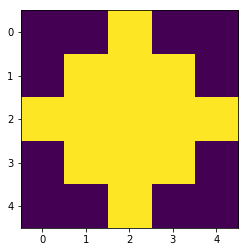

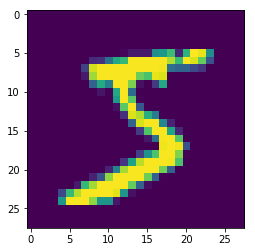

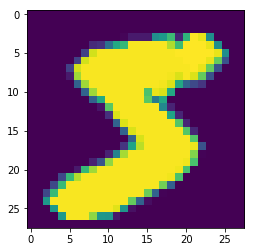

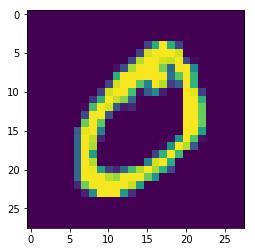

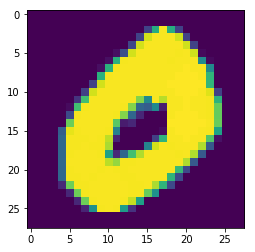

In [6]:
import skimage.morphology as skm
dil_x_train=np.zeros(x_train.shape)
print(x_train.shape)
#SE=skm.rectangle(10,1)
#SE=np.random.rand(21,21)
#SE=SE>(SE.max()-.01)
#SE=(SE>(SE.max()-.01))*np.power((SE-.1),3)
SE=skm.disk(2)
#SE2=skm.disk(2)
for i in range(x_train.shape[0]):
    dil_x_train[i,:,:,0]=skm.dilation(x_train[i,:,:][:,:,0],SE)
plt.imshow(SE,clim=[0,1])
plt.show()
plt.imshow(x_train[[0][0],:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[[0][0],:,:,0],clim=[0,1])
plt.show()
plt.imshow(x_train[[1][0],:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[[1][0],:,:,0],clim=[0,1])
plt.show()
#print(SE)

In [7]:
SE.shape

(5, 5)

In [8]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = MaxPlusDense(img_rows*img_cols,b_constraint=non_neg_ones(),name='MaxPlus7')(x1)
xx=Reshape([28,28,1])(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(240, 28, 28, 1)
(240, 28, 28, 1)


In [9]:
epochs = 100

decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])
decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
240/240 [==============================] - 2s 10ms/step - loss: 0.6222 - mean_absolute_error: 0.6640
Epoch 2/100
240/240 [==============================] - 2s 10ms/step - loss: 0.4102 - mean_absolute_error: 0.5333
Epoch 3/100
240/240 [==============================] - 2s 10ms/step - loss: 0.2452 - mean_absolute_error: 0.4063
Epoch 4/100
240/240 [==============================] - 2s 10ms/step - loss: 0.1408 - mean_absolute_error: 0.3021
Epoch 5/100
240/240 [==============================] - 2s 10ms/step - loss: 0.0758 - mean_absolute_error: 0.2131
Epoch 6/100
240/240 [==============================] - 2s 10ms/step - loss: 0.0371 - mean_absolute_error: 0.1357
Epoch 7/100
240/240 [==============================] - 3s 11ms/step - loss: 0.0186 - mean_absolute_error: 0.0803
Epoch 8/100
240/240 [==============================] - 2s 9ms/step - loss: 0.0099 - mean_absolute_error: 0.0417
Epoch 9/100
240/240 [==============================] - 2s 10ms/step - loss: 0.0062 - mean_absolut

KeyboardInterrupt: 

In [18]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_1
flatten_1
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_1


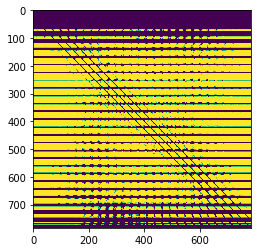

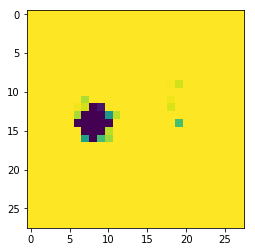

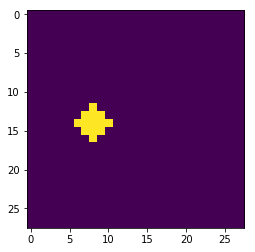

0.0
1.0


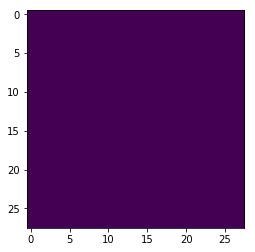

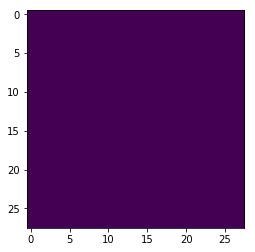

0.0
0.0


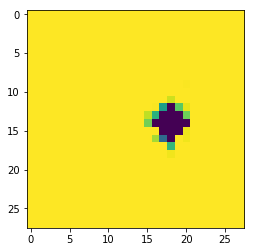

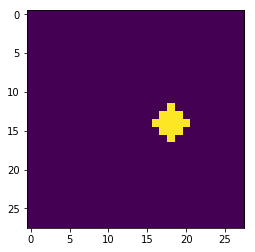

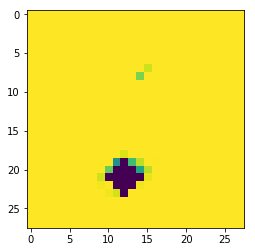

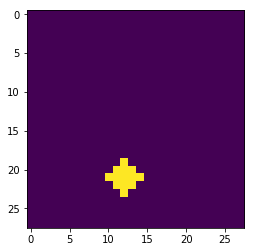

In [19]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [12]:
pred=decoder_model.predict(x_train[:,:,:,:])

In [13]:
print(pred.shape)
print(x_train.shape)


(240, 28, 28, 1)
(240, 28, 28, 1)


In [14]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

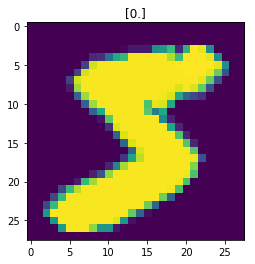

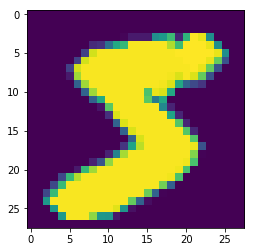

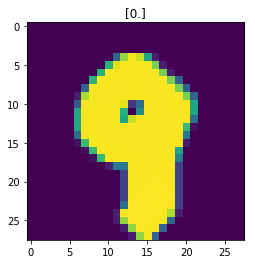

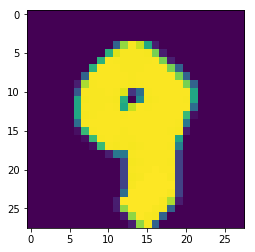

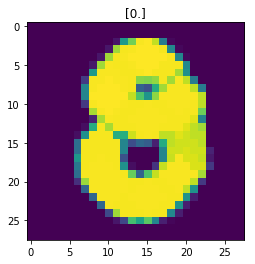

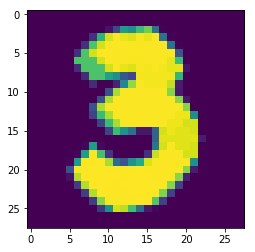

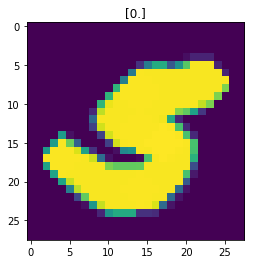

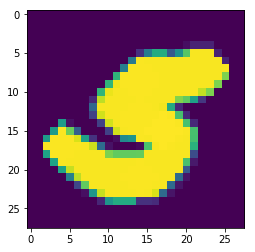

In [15]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-100][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [16]:
D11[0].min()

0.0

In [17]:
(i+1)%2

0